In [1]:
import glob, pickle, multiprocessing
from joblib import Parallel, delayed

# pyscience imports
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.formula.api as smf

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
font = {'family' : 'IBM Plex Sans',
                 'weight' : 'normal',
                 'size'   : 10}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [10, 10]
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import geopandas as gpd
import fiona
from matplotlib import animation
from IPython.display import display, HTML

# Data Ingest

US outline: from [census](https://www2.census.gov/geo/tiger/TIGER2017//STATE/tl_2017_us_state.zip)

In [2]:
us_outline = gpd.read_file("tl_2017_us_state.zip")
us_outline = us_outline.to_crs("EPSG:4326")

## Train network from [Sequeira, Nunn, Qian (2020)](https://scholar.harvard.edu/nunn/publications/migrants-and-making-america-short-and-long-run-effects-immigration-during-age-mass)

zipfile of gdb layers; unzips to directory. `fiona` can load layer names and these names can be passed to geopandas.

In [3]:
layerlist = fiona.listlayers('Railroads_Final_Oct_2018.gdb')
layerlist.sort()
len(layerlist)
layerlist[:5]

['rr_1830', 'rr_1834', 'rr_1839', 'rr_1847', 'rr_1850']

In [4]:
%%time
def readTrains(x):
    geom = gpd.read_file('Railroads_Final_Oct_2018.gdb', layer=x)['geometry']
    geom = geom.to_crs("EPSG:4326")
    return geom
train_files = Parallel(n_jobs=6)(delayed(readTrains)(f) for f in layerlist)

CPU times: user 1.01 s, sys: 345 ms, total: 1.35 s
Wall time: 34 s


### Trial run - final network

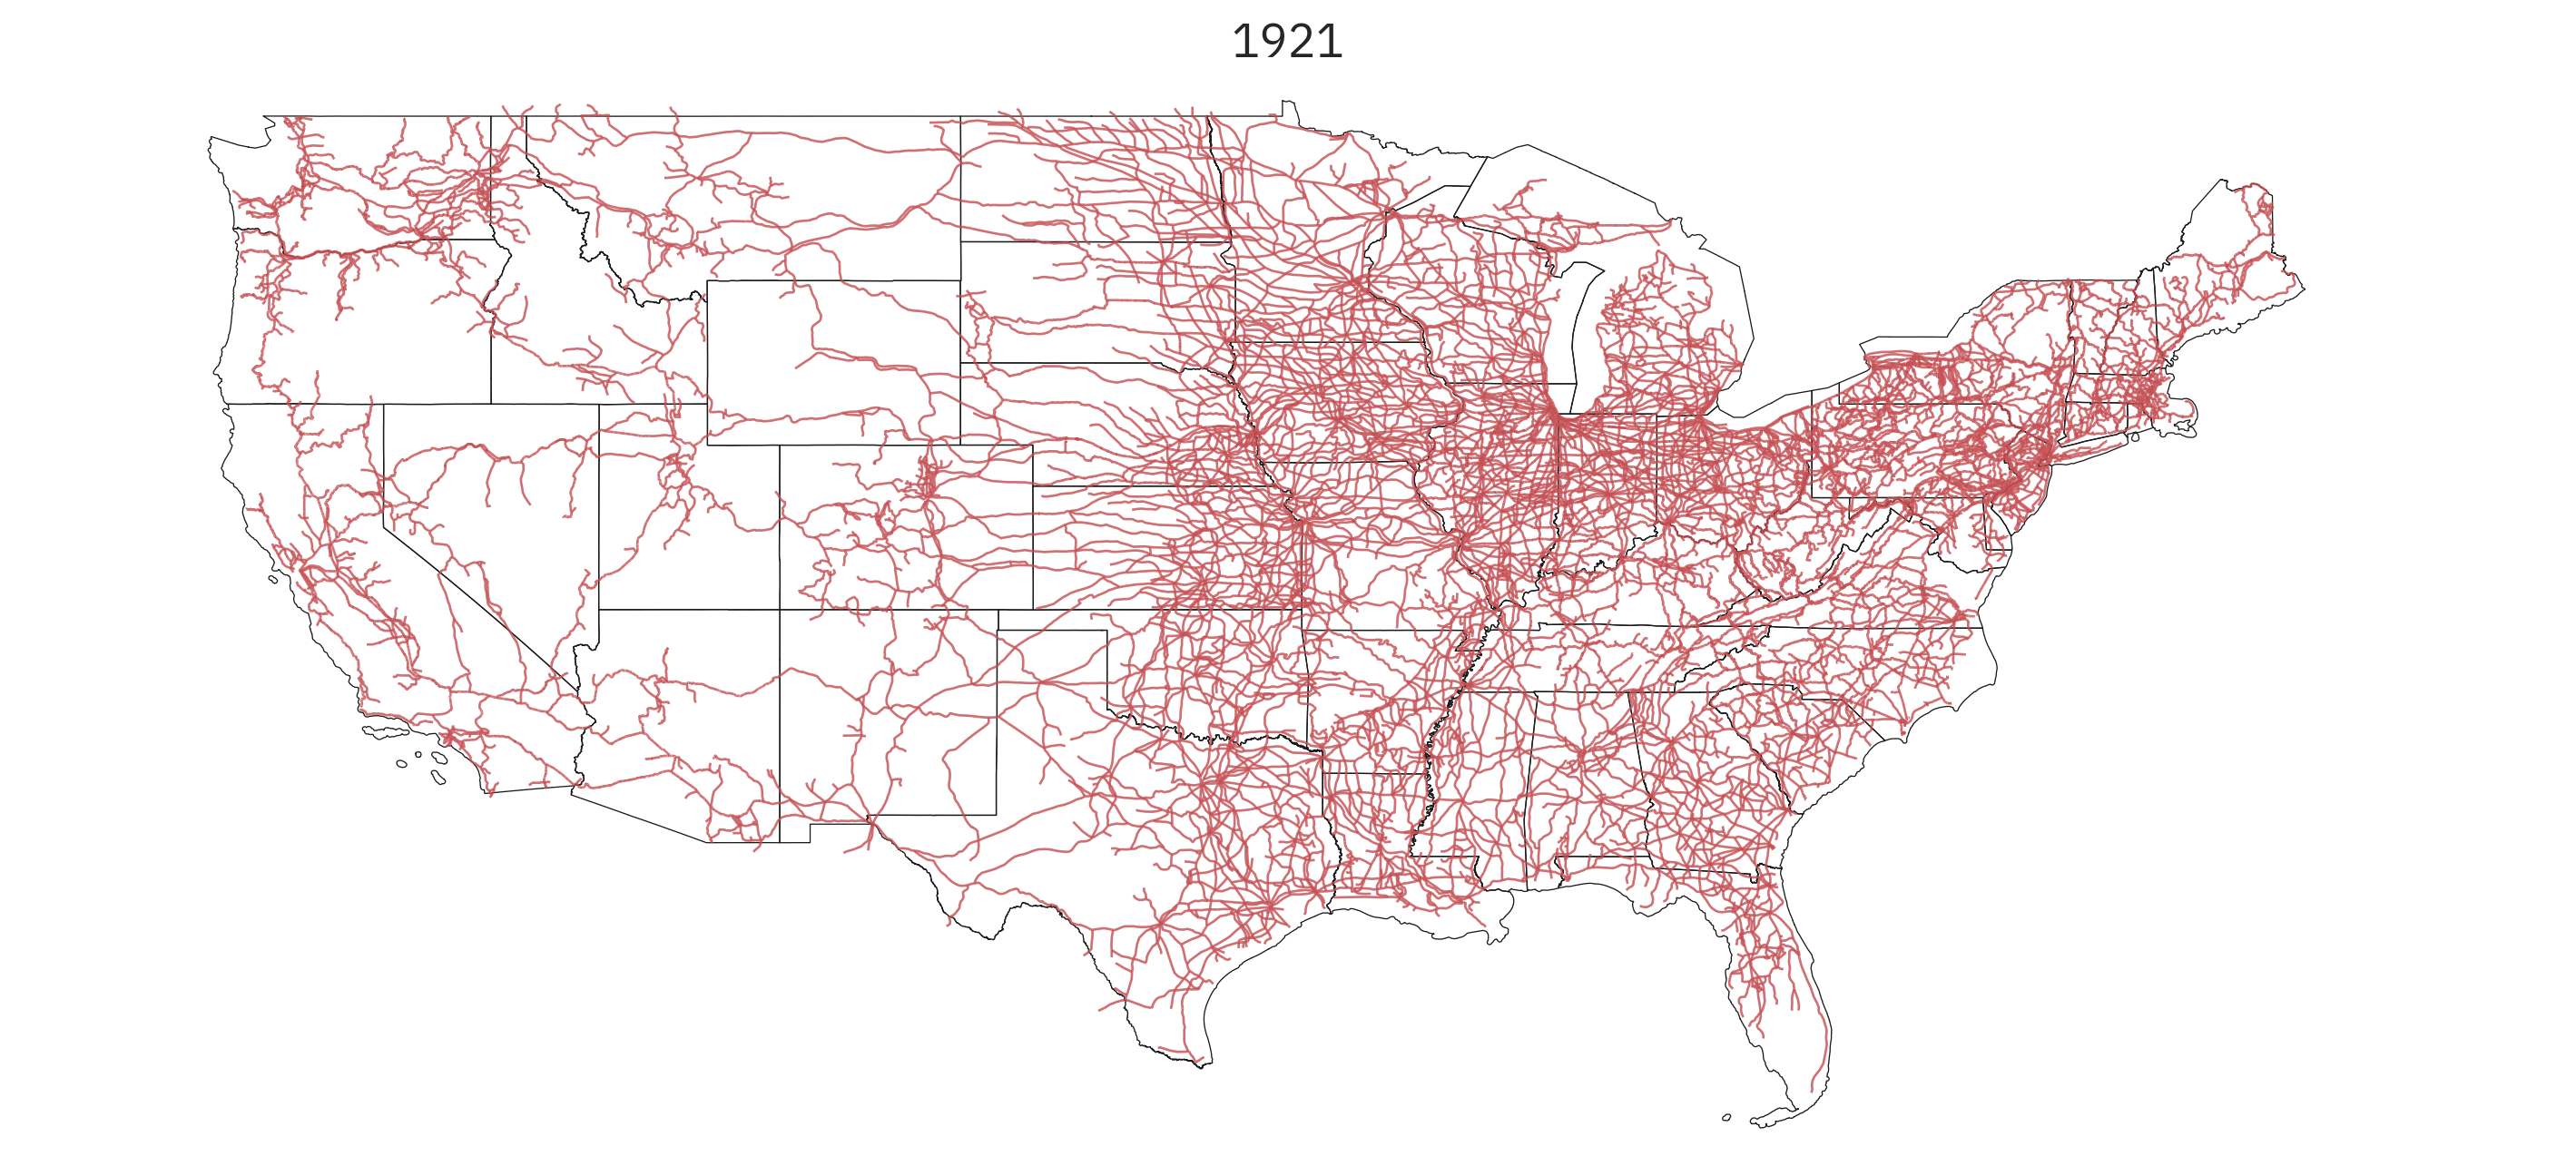

In [5]:
f, ax = plt.subplots(figsize = (15, 10), dpi = 120)
# plot CDs
train_files[-1].plot(facecolor = 'None', edgecolor = 'r', 
	linewidth = 0.8, alpha = 0.8, ax = ax)
# outline
us_outline.plot(facecolor = 'None', edgecolor = 'k', ax = ax)
ax.set_title(f"{layerlist[-1][3:]}")
# zoom in on mainland
ax.set_ylim(24, 50)
ax.set_xlim(-130, -60)
ax.set_axis_off()

# Animation

In [ ]:
def plot_animation(speed = 600, maps = train_files):
    f, ax = plt.subplots(figsize = (15, 10), dpi = 120)
    
    def animate(k):
        ax.clear()
        us_outline.plot(facecolor = 'None', edgecolor = 'k', 
            linewidth = 1.2, ax = ax)
        data = maps[k]
        # plot rail network
        data.plot(facecolor = 'None', edgecolor = 'r', linewidth = 0.8,
            alpha = 0.8, ax = ax)
        ax.set_title(f"Railway network in {layerlist[k][3:]}")
        # zoom in on mainland
        ax.set_ylim(24, 50)
        ax.set_xlim(-130, -60)
        ax.set_axis_off()
    ani = animation.FuncAnimation(
            f, animate, 
            frames = list(range(len(maps))), interval=speed,
            repeat=True, blit=False
        )
    f.tight_layout()
    return ani
# %%
ani = plot_animation()

In [12]:
dpi = 200
writer = animation.writers['ffmpeg'](fps=1)
ani.save('animation.mp4',writer=writer,dpi=dpi)

<Figure size 432x288 with 0 Axes>

In [9]:
%%time
HTML(ani.to_jshtml())

CPU times: user 2min, sys: 535 ms, total: 2min
Wall time: 2min 1s


<Figure size 432x288 with 0 Axes>